!pip install git+https://github.com/CC-RMD-EpiBio/autoencirt.git

In [1]:
%pylab inline
import numpy as np
import sys
sys.path.append('../bayesianquilts')

import matplotlib.pyplot as plt


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from factor_analyzer import FactorAnalyzer

In [3]:
import tensorflow as tf
import autoencirt
from autoencirt.irt import GRModel, FactorizedGRModel
from autoencirt.data.rwa import item_text, get_data

dim = 2

In [4]:
pd_data = get_data(reorient=True, pandas=True)
responses = pd_data[0].iloc[:, :22]
fa = FactorAnalyzer(n_factors=dim)
fa.fit(responses)
loadings = fa.loadings_
loadings.shape


(22, 2)

In [5]:
tfdata, num_people = get_data(reorient=True)
item_names = [f"Q{j}" for j in range(1, 23)]
scale_indices = [
    [1, 3, 5, 7, 8, 10, 12, 14, 15, 17, 19, 20],
    [0, 2, 4, 6, 9, 11, 13, 16, 18, 21],
]
fgrm = FactorizedGRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=10,
    scale_indices=scale_indices,
    discrimination_guess=0.5*tf.cast(np.abs(loadings).T, tf.float64)[
        tf.newaxis, :, :, tf.newaxis
    ],
)

grm = GRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=10,
    discrimination_guess=0.5*tf.cast(np.abs(loadings).T, tf.float64)[
        tf.newaxis, :, :, tf.newaxis
    ],
)

batch_size = 241


def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size * 10)
        else:
            out = tfdata

        if repeat:
            out = out.repeat()
        return out.batch(batch_size)

    return data_factory

In [6]:
losses = grm.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=2000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.0015)

Running optimization for 2000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-1


  2%|▏         | 40/2000 [00:07<03:57,  8.24it/s] 

Step 41: average-batch loss:410191.3586411597 rel loss: 2.4378865593675557e+302
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-2


  4%|▍         | 81/2000 [00:13<04:21,  7.34it/s]

Step 82: average-batch loss:398760.1879591109 rel loss: 0.02866678025345146
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-3


  6%|▌         | 122/2000 [00:18<04:24,  7.09it/s]

Step 123: average-batch loss:383898.5392190019 rel loss: 0.03871243889164918
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-4


  8%|▊         | 163/2000 [00:24<03:58,  7.69it/s]

Step 164: average-batch loss:372439.038211279 rel loss: 0.03076879658684454
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-5


 10%|█         | 204/2000 [00:29<03:55,  7.62it/s]

Step 205: average-batch loss:340932.3224644819 rel loss: 0.09241340192987846
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-6


 12%|█▏        | 245/2000 [00:35<03:48,  7.67it/s]

Step 246: average-batch loss:319225.6335210001 rel loss: 0.06799795086647974
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-7


 14%|█▍        | 286/2000 [00:41<03:53,  7.34it/s]

Step 287: average-batch loss:326123.4750733271 rel loss: 0.021151012053873267
New learning rate: 0.001485


 16%|█▋        | 327/2000 [00:47<03:37,  7.68it/s]

Step 328: average-batch loss:297387.95594480506 rel loss: 0.07343161395630997
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-8


 18%|█▊        | 368/2000 [00:53<03:20,  8.12it/s]

Step 369: average-batch loss:295973.14062486996 rel loss: 0.004780215248410987
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-9


 20%|██        | 409/2000 [00:59<03:28,  7.62it/s]

Step 410: average-batch loss:284459.0572492255 rel loss: 0.04047711993067787
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-10


 22%|██▎       | 450/2000 [01:04<03:08,  8.24it/s]

Step 451: average-batch loss:262549.2062106543 rel loss: 0.0834504562203552
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-11


 25%|██▍       | 491/2000 [01:09<03:21,  7.47it/s]

Step 492: average-batch loss:211710.06225415616 rel loss: 0.24013569981131155
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-12


 27%|██▋       | 532/2000 [01:15<03:03,  8.02it/s]

Step 533: average-batch loss:230209.05905483305 rel loss: 0.0803573798382567
New learning rate: 0.00147015


 29%|██▊       | 573/2000 [01:21<03:10,  7.48it/s]

Step 574: average-batch loss:232253.3915091419 rel loss: 0.08845222505255476
New learning rate: 0.0014554485


 31%|███       | 614/2000 [01:26<03:25,  6.75it/s]

Step 615: average-batch loss:274555.06967887806 rel loss: 0.228897639727527
New learning rate: 0.001440894015


 33%|███▎      | 655/2000 [01:32<02:49,  7.96it/s]

Step 656: average-batch loss:225089.73707124568 rel loss: 0.05944151426528418
New learning rate: 0.0014264850748499998


 35%|███▍      | 696/2000 [01:38<02:54,  7.48it/s]

Step 697: average-batch loss:192866.8884635059 rel loss: 0.09770040850851264
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-13


 37%|███▋      | 737/2000 [01:44<02:45,  7.62it/s]

Step 738: average-batch loss:226569.457629706 rel loss: 0.14875159926137063
New learning rate: 0.0014122202241015


 39%|███▉      | 778/2000 [01:49<02:48,  7.27it/s]

Step 779: average-batch loss:177038.21971561102 rel loss: 0.08940820108404604
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-14


 41%|████      | 819/2000 [01:55<02:24,  8.15it/s]

Step 820: average-batch loss:178068.0765942455 rel loss: 0.00578350088534491
New learning rate: 0.001398098021860485


 43%|████▎     | 860/2000 [02:00<02:24,  7.89it/s]

Step 861: average-batch loss:179072.6973989242 rel loss: 0.011361182988051718
New learning rate: 0.00138411704164188


 45%|████▌     | 901/2000 [02:05<02:28,  7.42it/s]

Step 902: average-batch loss:194302.26749949623 rel loss: 0.08885149929570416
New learning rate: 0.0013702758712254614


 47%|████▋     | 942/2000 [02:11<02:45,  6.39it/s]

Step 943: average-batch loss:138668.7436443807 rel loss: 0.2766988079853795
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-15


 49%|████▉     | 983/2000 [02:17<02:08,  7.89it/s]

Step 984: average-batch loss:160235.92254349653 rel loss: 0.13459640358273187
New learning rate: 0.0013565731125132067


 51%|█████     | 1024/2000 [02:22<02:00,  8.07it/s]

Step 1025: average-batch loss:154160.1741915273 rel loss: 0.10048918683693345
New learning rate: 0.0013430073813880746


 53%|█████▎    | 1065/2000 [02:28<02:19,  6.68it/s]

Step 1066: average-batch loss:144868.2591629243 rel loss: 0.04279416039348821
New learning rate: 0.001329577307574194


 55%|█████▌    | 1106/2000 [02:34<02:02,  7.29it/s]

Step 1107: average-batch loss:140274.5464356889 rel loss: 0.01144757072548732
New learning rate: 0.0013162815344984519


 57%|█████▋    | 1147/2000 [02:39<02:02,  6.94it/s]

Step 1148: average-batch loss:136237.1388798565 rel loss: 0.01784832524021638
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-16


 59%|█████▉    | 1188/2000 [02:45<01:42,  7.90it/s]

Step 1189: average-batch loss:111469.32759417634 rel loss: 0.2221939597218324
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-17


 61%|██████▏   | 1229/2000 [02:51<01:30,  8.56it/s]

Step 1230: average-batch loss:122032.85119681682 rel loss: 0.0865629500502568
New learning rate: 0.0013031187191534673


 64%|██████▎   | 1270/2000 [02:56<01:28,  8.27it/s]

Step 1271: average-batch loss:141370.23370989418 rel loss: 0.21150779291401242
New learning rate: 0.0012900875319619327


 66%|██████▌   | 1311/2000 [03:01<01:24,  8.18it/s]

Step 1312: average-batch loss:123707.68575817424 rel loss: 0.09892965088621603
New learning rate: 0.0012771866566423133


 68%|██████▊   | 1352/2000 [03:06<01:22,  7.88it/s]

Step 1353: average-batch loss:87410.41886791779 rel loss: 0.27524074404234306
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-18


 70%|██████▉   | 1393/2000 [03:12<01:21,  7.49it/s]

Step 1394: average-batch loss:99170.70470941378 rel loss: 0.11858628892429002
New learning rate: 0.00126441479007589


 72%|███████▏  | 1434/2000 [03:17<01:06,  8.53it/s]

Step 1435: average-batch loss:115526.0363987541 rel loss: 0.24337039863283608
New learning rate: 0.0012517706421751314


 74%|███████▍  | 1475/2000 [03:22<01:08,  7.68it/s]

Step 1476: average-batch loss:81756.1789106704 rel loss: 0.06915978746298077
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-19


 76%|███████▌  | 1516/2000 [03:28<01:02,  7.75it/s]

Step 1517: average-batch loss:92024.42550850156 rel loss: 0.11158175170441621
New learning rate: 0.00123925293575338


 78%|███████▊  | 1557/2000 [03:33<00:55,  8.03it/s]

Step 1558: average-batch loss:51759.627435308925 rel loss: 0.5795356914586036
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76/42316e4b-7805-47b3-bd5f-cc4e6f3b8a76-20


 80%|███████▉  | 1598/2000 [03:38<01:09,  5.77it/s]

Step 1599: average-batch loss:90941.51037072059 rel loss: 0.4308470661603022
New learning rate: 0.0012268604063958462


 82%|████████▏ | 1639/2000 [03:44<00:43,  8.34it/s]

Step 1640: average-batch loss:69161.48112159508 rel loss: 0.2516119291270148
New learning rate: 0.0012145918023318877


 84%|████████▍ | 1680/2000 [03:49<00:39,  8.15it/s]

Step 1681: average-batch loss:68077.70111491317 rel loss: 0.23969777786796612
New learning rate: 0.0012024458843085688


 86%|████████▌ | 1721/2000 [03:55<00:43,  6.48it/s]

Step 1722: average-batch loss:67307.62782910097 rel loss: 0.23099908428313
New learning rate: 0.001190421425465483


 88%|████████▊ | 1762/2000 [04:01<00:29,  7.94it/s]

Step 1763: average-batch loss:55060.076675500546 rel loss: 0.05994269240929308
New learning rate: 0.0011785172112108281
We are in a loss plateau
Restoring from a checkpoint


 90%|█████████ | 1803/2000 [04:06<00:25,  7.68it/s]

Step 1804: average-batch loss:71410.79170276434 rel loss: 0.2751847976878642
New learning rate: 0.00116673203909872
We are in a loss plateau
Restoring from a checkpoint


 92%|█████████▏| 1844/2000 [04:11<00:18,  8.60it/s]

Step 1845: average-batch loss:61635.45844194584 rel loss: 0.16022969985595087
New learning rate: 0.0011550647187077326
We are in a loss plateau
Restoring from a checkpoint


 94%|█████████▍| 1885/2000 [04:17<00:15,  7.21it/s]

Step 1886: average-batch loss:74840.21415691689 rel loss: 0.3083981918225819
New learning rate: 0.0011435140715206553
We are in a loss plateau
Restoring from a checkpoint


 96%|█████████▋| 1926/2000 [04:21<00:09,  7.66it/s]

Step 1927: average-batch loss:67772.2996977909 rel loss: 0.2362716380274156
New learning rate: 0.001132078930805449
We are in a loss plateau
Restoring from a checkpoint


 98%|█████████▊| 1967/2000 [04:27<00:04,  6.69it/s]

Step 1968: average-batch loss:57062.864903834365 rel loss: 0.09293675453314099
New learning rate: 0.0011207581414973942
We are in a loss plateau
Restoring from a checkpoint


100%|██████████| 2000/2000 [04:31<00:00,  6.62it/s]

Terminating because we are out of iterations


100%|██████████| 2000/2000 [04:31<00:00,  7.36it/s]


In [7]:
losses = grm.fit(
            data_factory_factory(shuffle=False, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=1000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.0005)

Running optimization for 1000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/adc616fb-c5b1-47d7-b149-4bbefa4df81c/adc616fb-c5b1-47d7-b149-4bbefa4df81c-1


  4%|▍         | 40/1000 [00:07<02:03,  7.75it/s]

Step 41: average-batch loss:59731.799350261594 rel loss: 1.6741501359034826e+303
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/adc616fb-c5b1-47d7-b149-4bbefa4df81c/adc616fb-c5b1-47d7-b149-4bbefa4df81c-2


  8%|▊         | 81/1000 [00:12<01:56,  7.90it/s]

Step 82: average-batch loss:32543.919506337454 rel loss: 0.8354211863948869
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/adc616fb-c5b1-47d7-b149-4bbefa4df81c/adc616fb-c5b1-47d7-b149-4bbefa4df81c-3


 12%|█▏        | 122/1000 [00:17<01:52,  7.80it/s]

Step 123: average-batch loss:44356.41703460466 rel loss: 0.26630864975076063
New learning rate: 0.000495


 16%|█▋        | 163/1000 [00:23<01:46,  7.88it/s]

Step 164: average-batch loss:46525.14781059361 rel loss: 0.30050905719148907
New learning rate: 0.00049005


 20%|██        | 204/1000 [00:28<01:40,  7.92it/s]

Step 205: average-batch loss:42217.29076667966 rel loss: 0.22913292361188164
New learning rate: 0.00048514950000000005


 24%|██▍       | 245/1000 [00:33<01:40,  7.55it/s]

Step 246: average-batch loss:34587.94390432434 rel loss: 0.05909644133924172
New learning rate: 0.00048029800499999997


 29%|██▊       | 286/1000 [00:38<01:33,  7.62it/s]

Step 287: average-batch loss:46089.33951171006 rel loss: 0.2938948604792021
New learning rate: 0.00047549502494999995
We are in a loss plateau
Restoring from a checkpoint


 33%|███▎      | 327/1000 [00:43<01:25,  7.89it/s]

Step 328: average-batch loss:36749.27799244972 rel loss: 0.11443377165059612
New learning rate: 0.0004707400747005
We are in a loss plateau
Restoring from a checkpoint


 37%|███▋      | 368/1000 [00:48<01:20,  7.90it/s]

Step 369: average-batch loss:35463.22457001447 rel loss: 0.08231922221041914
New learning rate: 0.00046603267395349497
We are in a loss plateau
Restoring from a checkpoint


 41%|████      | 409/1000 [00:53<01:12,  8.15it/s]

Step 410: average-batch loss:46459.8798764192 rel loss: 0.299526395830068
New learning rate: 0.00046137234721396004
We are in a loss plateau
Restoring from a checkpoint


 45%|████▌     | 450/1000 [00:58<01:10,  7.81it/s]

Step 451: average-batch loss:33938.98785998974 rel loss: 0.04110518437990655
New learning rate: 0.00045675862374182043
We are in a loss plateau
Restoring from a checkpoint


 49%|████▉     | 491/1000 [01:03<01:05,  7.82it/s]

Step 492: average-batch loss:57642.97227371846 rel loss: 0.435422598407969
New learning rate: 0.0004521910375044022
We are in a loss plateau
Restoring from a checkpoint


 53%|█████▎    | 532/1000 [01:09<01:03,  7.36it/s]

Step 533: average-batch loss:44364.08327509086 rel loss: 0.2664354337146888
New learning rate: 0.0004476691271293582
We are in a loss plateau
Restoring from a checkpoint


 57%|█████▋    | 573/1000 [01:14<00:55,  7.64it/s]

Step 574: average-batch loss:36604.927480292245 rel loss: 0.11094156589003489
New learning rate: 0.0004431924358580646
We are in a loss plateau
Restoring from a checkpoint


 61%|██████▏   | 614/1000 [01:19<00:52,  7.34it/s]

Step 615: average-batch loss:30650.85990587656 rel loss: 0.06176203885548882
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/adc616fb-c5b1-47d7-b149-4bbefa4df81c/adc616fb-c5b1-47d7-b149-4bbefa4df81c-4


 66%|██████▌   | 655/1000 [01:24<00:44,  7.80it/s]

Step 656: average-batch loss:43152.91939216027 rel loss: 0.2897152652099593
New learning rate: 0.00043876051149948394


 70%|██████▉   | 696/1000 [01:30<00:38,  7.87it/s]

Step 697: average-batch loss:38351.7391394585 rel loss: 0.20079608920938935
New learning rate: 0.00043437290638448915


 74%|███████▎  | 737/1000 [01:35<00:32,  7.98it/s]

Step 738: average-batch loss:34615.336455408746 rel loss: 0.11452948188555664
New learning rate: 0.00043002917732064424


 78%|███████▊  | 778/1000 [01:40<00:32,  6.79it/s]

Step 779: average-batch loss:41674.33331408788 rel loss: 0.26451469121606486
New learning rate: 0.0004257288855474378


 82%|████████▏ | 819/1000 [01:45<00:23,  7.73it/s]

Step 820: average-batch loss:41405.359900199306 rel loss: 0.25973690411687445
New learning rate: 0.0004214715966919634
We are in a loss plateau
Restoring from a checkpoint


 86%|████████▌ | 860/1000 [01:50<00:18,  7.59it/s]

Step 861: average-batch loss:43675.0143878325 rel loss: 0.2982060719271191
New learning rate: 0.00041725688072504375
We are in a loss plateau
Restoring from a checkpoint


 90%|█████████ | 901/1000 [01:55<00:12,  7.88it/s]

Step 902: average-batch loss:43219.35251704755 rel loss: 0.29080705469184065
New learning rate: 0.00041308431191779333
We are in a loss plateau
Restoring from a checkpoint


 94%|█████████▍| 942/1000 [02:01<00:07,  7.78it/s]

Step 943: average-batch loss:30170.717965119387 rel loss: 0.015914170200134775
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/adc616fb-c5b1-47d7-b149-4bbefa4df81c/adc616fb-c5b1-47d7-b149-4bbefa4df81c-5


 98%|█████████▊| 983/1000 [02:06<00:02,  7.81it/s]

Step 984: average-batch loss:32496.594918635965 rel loss: 0.07157294354500959
New learning rate: 0.00040895346879861536


100%|██████████| 1000/1000 [02:08<00:00,  8.48it/s]

Terminating because we are out of iterations


100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


In [8]:
params = grm.sample(256)
discrim = params['discriminations']
discrim.shape

TensorShape([256, 1, 2, 22, 1])

In [9]:
discrim_mean = np.mean(discrim, axis=0)

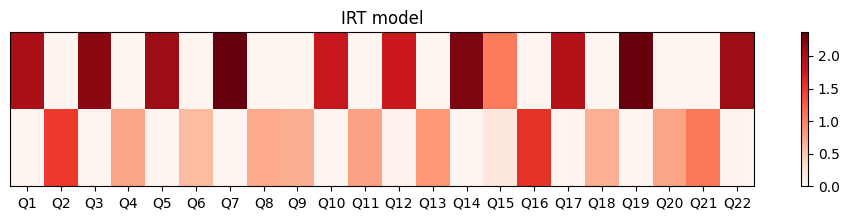

In [10]:
_ = plt.figure(figsize=(12, 2))
plt.pcolormesh(discrim_mean[0, ..., 0], vmin=0, cmap="Reds")
_ = plt.colorbar()
_ = plt.title("IRT model")
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

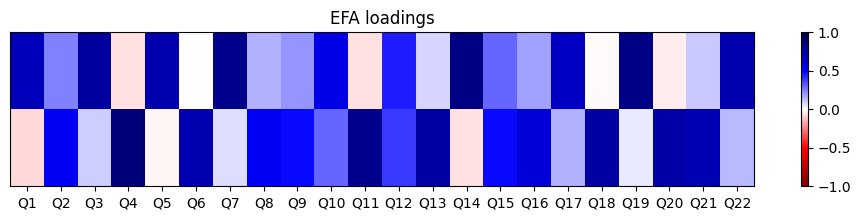

In [11]:
_ = plt.figure(figsize=(12, 2))

plt.pcolormesh(loadings.T, cmap="seismic_r", vmin=-1, vmax=1)
plt.colorbar()
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)
_ = plt.title("EFA loadings")

In [12]:
discrim_mean[0, ..., 0]

array([[6.03900059e-03, 1.48919172e+00, 7.51507758e-03, 7.60253983e-01,
        1.63924677e-03, 5.83817840e-01, 5.15780241e-03, 7.27656996e-01,
        6.84128965e-01, 1.26956633e-02, 7.77576647e-01, 3.95397958e-02,
        8.53252887e-01, 4.37168702e-03, 1.82166759e-01, 1.55458881e+00,
        1.02620435e-02, 6.76212704e-01, 3.89843042e-03, 7.60764528e-01,
        1.07335591e+00, 9.70555957e-03],
       [2.01951605e+00, 1.59461049e-02, 2.19293836e+00, 3.57898679e-03,
        2.11273541e+00, 2.51038877e-05, 2.36311753e+00, 7.35161860e-03,
        8.51908428e-03, 1.79404776e+00, 3.55459189e-03, 1.77493425e+00,
        4.99169599e-03, 2.25707182e+00, 1.05377062e+00, 1.33856420e-02,
        1.94989593e+00, 6.23533840e-04, 2.34946319e+00, 2.21818353e-03,
        6.30823591e-03, 2.09934625e+00]])

In [13]:
scale_indices = [np.where(discrim_mean[0, ..., 0][0, :] > .5)[0].tolist()]
scale_indices += [[i for i in range(22) if i not in scale_indices[0]]]
scale_indices

[[1, 3, 5, 7, 8, 10, 12, 15, 17, 19, 20],
 [0, 2, 4, 6, 9, 11, 13, 14, 16, 18, 21]]

In [14]:
difficulties = tf.cumsum(
    tf.concat(
        [params['difficulties0'], params['ddifficulties']], axis=-1
    ), axis=-1
)

In [15]:
difficulties_mean = tf.reduce_mean(difficulties, axis=[0, 1])
difficulties_mean.shape

TensorShape([2, 22, 9])

# Build fully factorized model

In [16]:
fgrm = FactorizedGRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=10,
    scale_indices=scale_indices,
    discrimination_guess=tf.cast(np.abs(loadings).T, tf.float64)[tf.newaxis, :, :, tf.newaxis]
)

# Fit by projecting the original model

In [17]:
fgrm.fit_projection(grm, data_factory_factory(shuffle=True, repeat=True), num_steps=500)

Running optimization for 500 steps of 1 accumulated batches, checking every 1 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-1


  0%|          | 0/500 [00:00<?, ?it/s]

Step 1: average-batch loss:0.7945366253467897 rel loss: 1.2585952215400166e+308
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-2


  0%|          | 1/500 [00:01<13:14,  1.59s/it]

Step 2: average-batch loss:0.7539278485943419 rel loss: 0.05386294832875675
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-3


  0%|          | 2/500 [00:01<06:17,  1.32it/s]

Step 3: average-batch loss:0.5147203145987882 rel loss: 0.46473303503089847
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-4


  1%|          | 3/500 [00:01<04:00,  2.07it/s]

Step 4: average-batch loss:0.3480448479719462 rel loss: 0.4788907739851869
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-5


  1%|          | 4/500 [00:02<02:56,  2.81it/s]

Step 5: average-batch loss:0.26688744357476896 rel loss: 0.30408850753760114
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-6


  1%|          | 5/500 [00:02<02:20,  3.52it/s]

Step 6: average-batch loss:0.20710418866250915 rel loss: 0.2886627030498201
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-7


  1%|          | 6/500 [00:02<01:58,  4.16it/s]

Step 7: average-batch loss:0.17185981000702555 rel loss: 0.2050763273510126
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-8


  1%|▏         | 7/500 [00:02<01:44,  4.71it/s]

Step 8: average-batch loss:0.15325671185329623 rel loss: 0.12138521000983622
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-9


  2%|▏         | 8/500 [00:02<01:35,  5.16it/s]

Step 9: average-batch loss:0.15219145630891825 rel loss: 0.006999443794109693
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-10


  2%|▏         | 9/500 [00:02<01:29,  5.49it/s]

Step 10: average-batch loss:0.13324323077283215 rel loss: 0.14220779116645066
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-11


  2%|▏         | 10/500 [00:03<01:25,  5.75it/s]

Step 11: average-batch loss:0.10232644587597757 rel loss: 0.3021387543775982
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-12


  2%|▏         | 11/500 [00:03<01:23,  5.88it/s]

Step 12: average-batch loss:0.08810263746984787 rel loss: 0.1614458864639284
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-13


  2%|▏         | 12/500 [00:03<01:20,  6.05it/s]

Step 13: average-batch loss:0.08640171635891591 rel loss: 0.01968619586058063
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-14


  3%|▎         | 13/500 [00:03<01:19,  6.12it/s]

Step 14: average-batch loss:0.0843337772419079 rel loss: 0.024520888126191985
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-15


  3%|▎         | 14/500 [00:03<01:18,  6.20it/s]

Step 15: average-batch loss:0.08627603774995639 rel loss: 0.022512166282804003
New learning rate: 0.95


  3%|▎         | 15/500 [00:03<01:15,  6.41it/s]

Step 16: average-batch loss:0.07765760848478884 rel loss: 0.0859692808905743
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-16


  3%|▎         | 16/500 [00:03<01:15,  6.42it/s]

Step 17: average-batch loss:0.0684749169987455 rel loss: 0.13410299549850596
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-17


  3%|▎         | 17/500 [00:04<01:21,  5.89it/s]

Step 18: average-batch loss:0.05609790255530457 rel loss: 0.22063239229379294
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-18


  4%|▎         | 18/500 [00:04<01:19,  6.08it/s]

Step 19: average-batch loss:0.05878018531101383 rel loss: 0.04563243109079944
New learning rate: 0.9025


  4%|▍         | 19/500 [00:04<01:15,  6.35it/s]

Step 20: average-batch loss:0.0626203189218675 rel loss: 0.10415814673031383
New learning rate: 0.8573749999999999


  4%|▍         | 20/500 [00:04<01:12,  6.61it/s]

Step 21: average-batch loss:0.06083071492378873 rel loss: 0.07780300419637715
New learning rate: 0.8145062499999999


  4%|▍         | 21/500 [00:04<01:10,  6.79it/s]

Step 22: average-batch loss:0.05509957291936873 rel loss: 0.0181186456271951
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-19


  4%|▍         | 22/500 [00:04<01:11,  6.68it/s]

Step 23: average-batch loss:0.05289136788599953 rel loss: 0.041749818952096306
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-20


  5%|▍         | 23/500 [00:05<01:12,  6.57it/s]

Step 24: average-batch loss:0.05218605020912841 rel loss: 0.013515444722194191
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-21


  5%|▍         | 24/500 [00:05<01:13,  6.50it/s]

Step 25: average-batch loss:0.050591910470687916 rel loss: 0.03150977544847032
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-22


  5%|▌         | 25/500 [00:05<01:13,  6.47it/s]

Step 26: average-batch loss:0.046442876806992314 rel loss: 0.08933627606528746
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-23


  5%|▌         | 26/500 [00:05<01:14,  6.39it/s]

Step 27: average-batch loss:0.046260049146698 rel loss: 0.00395217176952277
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-24


  5%|▌         | 27/500 [00:05<01:13,  6.41it/s]

Step 28: average-batch loss:0.04486103072154749 rel loss: 0.031185605917844757
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-25


  6%|▌         | 28/500 [00:05<01:13,  6.46it/s]

Step 29: average-batch loss:0.045605029576256326 rel loss: 0.01631396496442988
New learning rate: 0.7737809374999998


  6%|▌         | 29/500 [00:05<01:11,  6.62it/s]

Step 30: average-batch loss:0.04655177576093137 rel loss: 0.0363196679771524
New learning rate: 0.7350918906249998


  6%|▌         | 30/500 [00:06<01:12,  6.44it/s]

Step 31: average-batch loss:0.04165732007839156 rel loss: 0.07690630691381789
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-26


  6%|▌         | 31/500 [00:06<01:13,  6.41it/s]

Step 32: average-batch loss:0.04184757585892192 rel loss: 0.004546399083467897
New learning rate: 0.6983372960937497


  6%|▋         | 32/500 [00:06<01:10,  6.63it/s]

Step 33: average-batch loss:0.043098555435109404 rel loss: 0.03344045623264132
New learning rate: 0.6634204312890623


  7%|▋         | 33/500 [00:06<01:08,  6.79it/s]

Step 34: average-batch loss:0.04000602361761511 rel loss: 0.04127619571892095
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-27


  7%|▋         | 34/500 [00:06<01:09,  6.74it/s]

Step 35: average-batch loss:0.039563816487266666 rel loss: 0.011177059485420514
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-28


  7%|▋         | 35/500 [00:06<01:10,  6.61it/s]

Step 36: average-batch loss:0.03775385234215757 rel loss: 0.04794117772951111
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/78fab527-1c45-4d46-931b-843f8c666cc5/78fab527-1c45-4d46-931b-843f8c666cc5-29


  7%|▋         | 36/500 [00:07<01:10,  6.57it/s]

Step 37: average-batch loss:0.039148940481689445 rel loss: 0.0356353996395989


  7%|▋         | 37/500 [00:07<01:08,  6.72it/s]

Terminating because the loss converged


  7%|▋         | 37/500 [00:07<01:30,  5.10it/s]


<tf.Tensor: shape=(37,), dtype=float64, numpy=
array([0.79453663, 0.75392785, 0.51472031, 0.34804485, 0.26688744,
       0.20710419, 0.17185981, 0.15325671, 0.15219146, 0.13324323,
       0.10232645, 0.08810264, 0.08640172, 0.08433378, 0.08627604,
       0.07765761, 0.06847492, 0.0560979 , 0.05878019, 0.06262032,
       0.06083071, 0.05509957, 0.05289137, 0.05218605, 0.05059191,
       0.04644288, 0.04626005, 0.04486103, 0.04560503, 0.04655178,
       0.04165732, 0.04184758, 0.04309856, 0.04000602, 0.03956382,
       0.03775385, 0.03914894])>

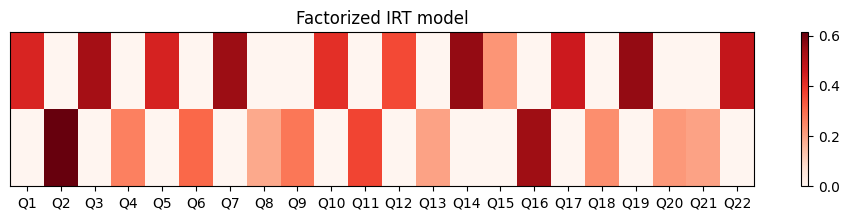

In [18]:
_ = plt.figure(figsize=(12, 2))

fparams = fgrm.sample(256)
fdiscrim = fparams['discriminations']
fdiscrim_mean = np.mean(fdiscrim, axis=0)
plt.pcolormesh(fdiscrim_mean[0, ..., 0], vmin=0, cmap='Reds')
_ = plt.colorbar()
_ = plt.title("Factorized IRT model")
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

In [19]:
item_names

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'Q16',
 'Q17',
 'Q18',
 'Q19',
 'Q20',
 'Q21',
 'Q22']

In [20]:
item_text

['The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'Women should have to promise to obey their husbands when they get married.',
 'Our country desperately needs a mighty leader who will do what has to be done to destroy the radical new ways and sinfulness that are ruining us.',
 'Gays and lesbians are just as healthy and moral as anybody else.',
 "It is always better to trust the judgement of the proper authorities in government and religion than to listen to the noisy rabble-rousers in our society who are trying to create doubt in people's minds.",
 'Atheists and others who have rebelled against the established religions are no doubt every bit as good and virtuous as those who attend church regularly.',
 'The only way our country can get through the crisis ahead is to get back to our traditional values, put some tough leaders in power, and silence the troublemakers 

In [21]:
{name: text for j, (name, text) in enumerate(zip(item_names, item_text))}

{'Q1': 'The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'Q2': 'Women should have to promise to obey their husbands when they get married.',
 'Q3': 'Our country desperately needs a mighty leader who will do what has to be done to destroy the radical new ways and sinfulness that are ruining us.',
 'Q4': 'Gays and lesbians are just as healthy and moral as anybody else.',
 'Q5': "It is always better to trust the judgement of the proper authorities in government and religion than to listen to the noisy rabble-rousers in our society who are trying to create doubt in people's minds.",
 'Q6': 'Atheists and others who have rebelled against the established religions are no doubt every bit as good and virtuous as those who attend church regularly.',
 'Q7': 'The only way our country can get through the crisis ahead is to get back to our traditional values, put some tough leader